author:leezeeyee   
date:2021/5/11

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
import scipy
import scipy.linalg

In [276]:
from datetime import datetime
from functools import wraps 

In [136]:
M=np.random.rand(3,3)

In [137]:
M

array([[0.10252966, 0.66596766, 0.95956141],
       [0.31412641, 0.49532295, 0.30373635],
       [0.18210204, 0.86132001, 0.85865439]])

In [138]:
P,L,U=scipy.linalg.lu(M)

## backward & forward substitution

In [277]:
def timer(func):
    @wraps(func)
    def layer(*args,**kwargs):
        #print(args)
        def count(*args,**kwargs):
            start=datetime.now()
            res=func(*args,**kwargs)
            time=(datetime.now()-start)
            return res,time
        return count(*args,**kwargs)
    return layer

In [279]:
@timer
def forward(L,b):
    d=np.shape(L)[0]
    Y=np.zeros(d)
    for i in range(d):
        l=L[i]
        Y[i]=b[i]
        for c in range(i):
            Y[i]-=Y[c]*l[c]
        Y[i]=Y[i]/l[i]
    return Y

In [281]:
@timer
# optimize
def forward_o(L,b):
    d=np.shape(L)[0]
    Y=np.copy(b)
    for i in range(d):
        l=L[i]
        Y[i]=Y[i]/l[i]
        Y[i+1:]-=Y[i]*L[i+1:,i]
    return Y

In [282]:
timel_o=[]
timel=[]
for d in range(50,800,50):
    
    M=np.random.rand(d,d)
    b=np.random.rand(d)
    P,L,U=scipy.linalg.lu(M)
    _,time=forward_o(L,b)
    # print(time.total_seconds())
    timel_o.append(time.total_seconds())
    _,time=forward(L,b)
    timel.append(time.total_seconds())
    # print(time.total_seconds())



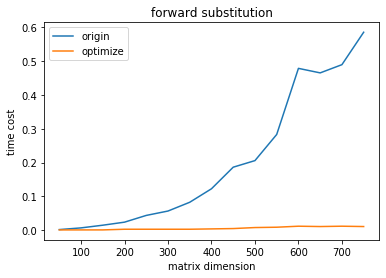

In [249]:
plt.plot(range(50,800,50),timel,label='origin')
plt.plot(range(50,800,50),timel_o,label='optimize')
plt.legend()
plt.xlabel('matrix dimension')
plt.ylabel('time cost')
plt.title('forward substitution')
plt.show()

In [268]:
_=forward_o(L,b)

In [211]:
_=forward(L,b)

0:00:00.098731


In [285]:
@timer
def backward(U,b):
    d=np.shape(U)[0]
    Y=np.zeros(d)
    for i in range(d-1,-1,-1):
        #i=d-m-1
        l=U[i]
        Y[i]=b[i]
        for c in range(d-1,i,-1):
            Y[i]-=Y[c]*l[c]
        Y[i]=Y[i]/l[i]
    return Y

In [286]:
@timer
# optimize
def backward_o(L,b):
    d=np.shape(L)[0]
    Y=np.copy(b)
    for i in range(d-1,-1,-1):
        l=L[i]
        Y[i]=Y[i]/l[i]
        Y[:i]-=Y[i]*L[:i,i]
    return Y

In [265]:
timeb_o=[]
timeb=[]
for d in range(50,800,50):
    M=np.random.rand(d,d)
    b=np.random.rand(d)
    P,L,U=scipy.linalg.lu(M)
    res,time=backward_o(L,b)
    # print(res)
    # print(time.total_seconds())
    timeb_o.append(time.total_seconds())
    res,time=backward(L,b)
    # print(res)
    timeb.append(time.total_seconds())
    # print(time.total_seconds())

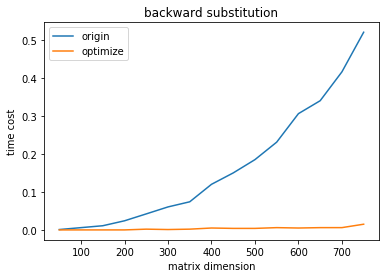

In [267]:
plt.plot(range(50,800,50),timeb,label='origin')
plt.plot(range(50,800,50),timeb_o,label='optimize')
plt.legend()
plt.xlabel('matrix dimension')
plt.ylabel('time cost')
plt.title('backward substitution')
plt.show()

forward(L,b)

forward_o(L,b)

np.dot(np.linalg.inv(L),b)

## time consuming

In [296]:
@timer
def inv(L,b):
    return np.dot(np.linalg.inv(L),b)

In [288]:
d=4
M=np.random.rand(d,d)
b=np.random.rand(d)
P,L,U=scipy.linalg.lu(M)

In [294]:
pb=np.dot(np.linalg.inv(P),b)
Y=forward.__wrapped__(L,pb)
print(np.allclose(np.dot(L,Y),pb))
X=backward.__wrapped__(U,Y)
# print(np.dot(U,X))
# print(((np.dot(M,X))-b))
print(np.allclose(np.dot(M,X),b,rtol=0.1))

True
True


## 置换矩阵
$P$为$LU$分解时的置换矩阵，为了防止因为主元为零（在数值计算中主元值很小）而交换矩阵两行的变换。如果我们想写出更普适的 $LU$ 分解式的话，必须把行交换情况考虑进去，即：$PA$ 先用行交换使得主元位置不为 0，行顺序正确。其后再用 $LU$ 分解。

In [92]:
print(np.dot(P,np.dot(L,U)))
print(M)
print(np.allclose(np.dot(P,np.dot(L,U)),M))

[[0.76485184 0.98605722 0.38653124 0.60066463]
 [0.23076152 0.77537277 0.16908712 0.2003375 ]
 [0.82089899 0.69583508 0.0227756  0.23570014]
 [0.80933263 0.29578319 0.38680694 0.9643746 ]]
[[0.76485184 0.98605722 0.38653124 0.60066463]
 [0.23076152 0.77537277 0.16908712 0.2003375 ]
 [0.82089899 0.69583508 0.0227756  0.23570014]
 [0.80933263 0.29578319 0.38680694 0.9643746 ]]
True


In [297]:
res=inv.__wrapped__(M,b)
print(np.allclose(np.dot(M,res),b))
print((np.dot(M,res)-b))

True
[1.11022302e-16 1.11022302e-16 0.00000000e+00 0.00000000e+00]


## 精度低

In [315]:
@timer
def lu_s(M,b,optimize=True):
    P,L,U=scipy.linalg.lu(M)
    b=np.dot(np.linalg.inv(P),b)
    if optimize is False:
        Y=forward.__wrapped__(L,b)#np.dot(np.linalg.inv(L),b)
        X=backward.__wrapped__(U,Y)#np.dot(np.linalg.inv(U),Y)
    else:
        Y=forward_o.__wrapped__(L,b)#np.dot(np.linalg.inv(L),b)
        X=backward_o.__wrapped__(U,Y)#np.dot(np.linalg.inv(U),Y)
    return X

In [310]:
t1s=[]
t2s=[]
t3s=[]
ranges=range(100,400,40)
for d in ranges:
    # print('~~~~~~~~~~~~d='+str(d)+'~~~~~~~~~~~')
    #d=400
    M=np.random.rand(d,d)
    b=np.random.rand(d)
    # for i in range(3):
    res,t1=lu_s(M,b)
    res,t2=lu_s(M,b,optimize=False)
    res,t3=inv(M,b)
    t1s.append(t1.total_seconds())
    t2s.append(t2.total_seconds())
    t3s.append(t3.total_seconds())


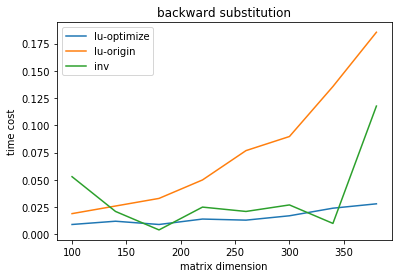

In [313]:
plt.plot(ranges,t1s,label='lu-optimize')
plt.plot(ranges,t2s,label='lu-origin')
plt.plot(ranges,t3s,label='inv')
plt.legend()
plt.xlabel('matrix dimension')
plt.ylabel('time cost')
plt.title('backward substitution')
plt.show()

In [316]:
    d=290
    M=np.random.rand(d,d)
    b=np.random.rand(d)
    # for i in range(9):
    x1=lu_s.__wrapped__(M,b)
    x2=inv.__wrapped__(M,b)
    print(x1[:5])
    print(x2[:5])

[ 0.08312682 -2.25285982  0.35208532  0.86766977 -5.34145184]
[ 0.08312682 -2.25285982  0.35208532  0.86766977 -5.34145184]
